In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random as rd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d jagadeesh23/weather-classification

In [ ]:
!ls

kaggle.json  weather-classification.zip  WPI


In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
!mv Data WPI

In [8]:
%cd 'Data'

/content/gdrive/My Drive/Kaggle/Data


In [ ]:
if os.path.isdir('train') is False:  
  os.mkdir('train')
if os.path.isdir('valid') is False:  
  os.mkdir('valid')
if os.path.isdir('test') is False:  
  os.mkdir('test')

for i in range(0, 5):
    lists=os.listdir(str(i))
    if os.path.isdir('valid/'+str(i)) is False:
      os.mkdir('valid/'+str(i))
    if os.path.isdir('train/'+str(i)) is False:  
      os.mkdir('train/'+str(i))
    if os.path.isdir('test/'+str(i)) is False:
      os.mkdir('test/'+str(i))

    rd.shuffle(lists) 

    tle=int(0.8*len(lists))
    vle= tle + int(0.15*len(lists))
    tele = vle + int(0.05*len(lists))

    c=0
    for j in lists:
        if c<=tle:
          shutil.copy(str(i)+'/'+j,"train/"+str(i)+"/")
          c=c+1
        elif c>tle & c<=vle:
          shutil.copy(str(i)+'/'+j,"valid/"+str(i)+"/")
          c=c+1
        else:
          shutil.copy(str(i)+'/'+j,"test/"+str(i)+"/")
          c=c+1    


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    )
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen= tf.keras.preprocessing.image.ImageDataGenerator()  

In [7]:
os.listdir()

['kaggle.json', 'Data', 'weather-classification.zip']

In [6]:
train_generator = train_datagen.flow_from_directory('Data/train',batch_size=32,target_size=(100, 100),
                class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(
        'Data/valid', target_size=(100, 100), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('Data/test',batch_size=32,target_size=(100, 100),class_mode='categorical')

Found 3702 images belonging to 5 classes.
Found 924 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


In [7]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x =  tf.keras.layers.BatchNormalization()(x)
  x =  tf.keras.layers.Activation('relu')(x)

  #second block # bottleneck (but size kept same with padding)
  x =  tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x =  tf.keras.layers.BatchNormalization()(x)
  x =  tf.keras.layers.Activation('relu')(x)

  # third block activation used after adding the input
  x =  tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x =  tf.keras.layers.BatchNormalization()(x)
  x =  tf.keras.layers.Activation('relu')(x)

  # add the input 
  x =  tf.keras.layers.Add()([x, x_skip])
  x =  tf.keras.layers.Activation('relu')(x)

  return x

In [8]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x =  tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x =  tf.keras.layers.BatchNormalization()(x)
  x =  tf.keras.layers.Activation('relu')(x)

  # second block
  x =  tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x =  tf.keras.layers.BatchNormalization()(x)
  x =  tf.keras.layers.Activation('relu')(x)

  #third block
  x =  tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x =  tf.keras.layers.BatchNormalization()(x)

  # shortcut 
  x_skip =  tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_skip)
  x_skip =  tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x =  tf.keras.layers.Add()([x, x_skip])
  x =  tf.keras.layers.Activation('relu')(x)

  return x


In [9]:
input_im = tf.keras.layers.Input(shape=(100,100,3))
x =  tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_im)

# 1st stage
# here we perform maxpooling, see the figure above

x = tf.keras.layers.Conv2D(64,kernel_size=(7, 7), strides=(2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

#2nd stage 
# frm here on only conv block and identity block, no pooling

x = res_conv(x, s=1, filters=(64, 256))
x = res_identity(x, filters=(64, 256))

# 3rd stage

x = res_conv(x, s=2, filters=(128, 512))
x = res_identity(x, filters=(128, 512))
x = res_identity(x, filters=(128, 512))

# 4th stage

x = res_conv(x, s=2, filters=(256, 1024))
x = res_identity(x, filters=(256, 1024))
x = res_identity(x, filters=(256, 1024))
x = res_identity(x, filters=(256, 1024))

# ends with average pooling and dense connection

x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

# define the model 

model = tf.keras.models.Model(inputs=input_im, outputs=x, name='Resnet50')

In [10]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [11]:
checkpoint_path = "Checkpoints/training1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 2 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=2)

In [27]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 50, 50, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 50, 50, 64)   256         conv2d_91[0][0]                  
___________________________________________________________________________________________

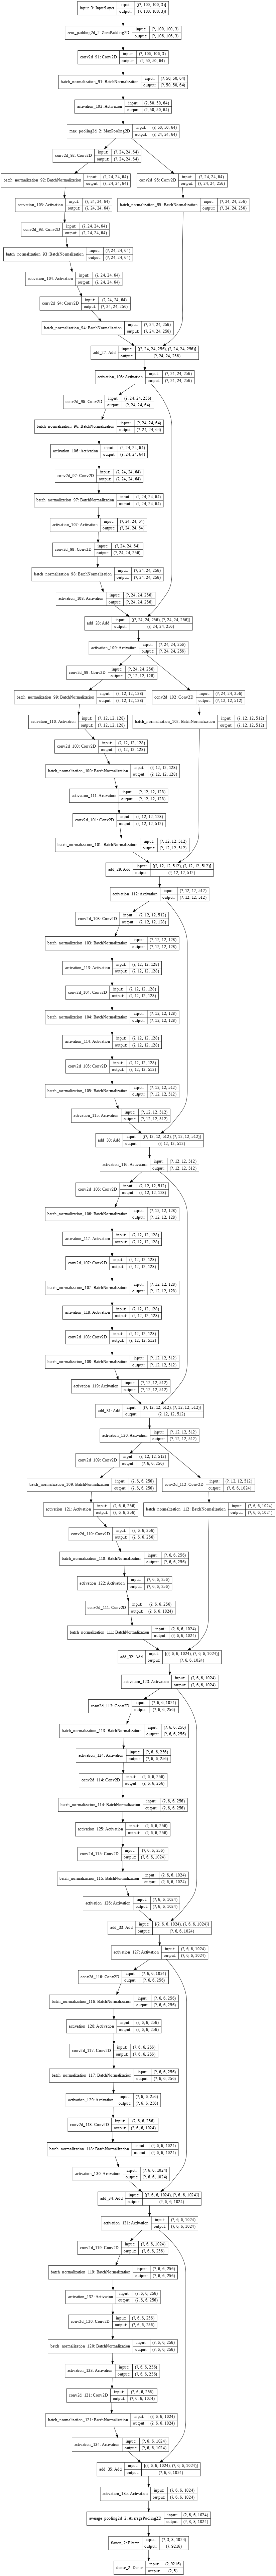

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['AUC'])

In [13]:
history =model.fit(train_generator,epochs=100,validation_data=valid_generator,callbacks=[cp_callback,reduce_lr],verbose=2,steps_per_epoch=3702 // 32)

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
115/115 - 2108s - loss: 11.2984 - auc: 0.6627 - val_loss: 11.3374 - val_auc: 0.4722 - lr: 0.0010
Epoch 2/100

Epoch 00002: saving model to Checkpoints/training1/cp-0002.ckpt
115/115 - 41s - loss: 8.9169 - auc: 0.7446 - val_loss: 256.5023 - val_auc: 0.5012 - lr: 9.5000e-04
Epoch 3/100
115/115 - 38s - loss: 7.7945 - auc: 0.7721 - val_loss: 13.4535 - val_auc: 0.6593 - lr: 9.0250e-04
Epoch 4/100

Epoch 00004: saving model to Checkpoints/training1/cp-0004.ckpt
115/115 - 38s - loss: 6.6389 - auc: 0.8032 - val_loss: 6.3927 - val_auc: 0.7629 - lr: 8.5737e-04
Epoch 5/100
115/115 - 38s - loss: 5.6631 - auc: 0.8260 - val_loss: 5.4831 - val_auc: 0.7133 - lr: 8.1451e-04
Epoch 6/100

Epoch 00006: saving model to Checkpoints/training1/cp-0006.ckpt
115/115 - 38s - loss: 5.1569 - auc: 0.8302 - val_loss: 5.5498 - val_auc: 0.6530 - lr: 7.7378e-04
Epoch 7/100
115/115 - 38s - loss: 4.5824 - auc: 0.8366 - val_loss: 

In [14]:
model.save('Models/my_model1.h5')

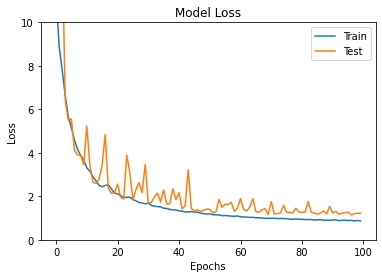

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,10)
plt.legend(['Train', 'Test'])
plt.show()
plt.savefig('loss.png')

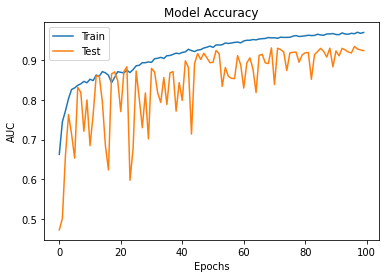

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['Train','Test'])
plt.show()
plt.savefig('auc.png')